In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
# from tensorflow.keras import layers
from sklearn import preprocessing
import mlflow
import socket
import json
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import matlab.engine
import random

# from udp_req import udp_send, udp_server


MODEL_PORT = 10652
DATA_PORT = 10653

FILE_NAME = "re_train.txt"
DATA_TMP = "re_rec.txt"
ORIGIN_DATA = 'CMAPSSData/train_FD001.txt'
TEST_DATA = 'CMAPSSData/test_FD001.txt'
RUL_FILE = "CMAPSSData/RUL_FD001.txt"
TIME_OUT = 3
MODEL_NAME = "regression_test"
REMAIN_NUM = 35



In [2]:
def reload_model(model_name:str, model_version:str = None) -> mlflow.pyfunc.PyFuncModel:
    '''
    The models are stored in the MLflow tracking server.
    Fetch the latest model
    '''
    if model_version:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/{model_version}"
        )
    else:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/Production"
        )
    return model


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def single_train(x_train,y_train):
    client = mlflow.tracking.MlflowClient()
    mlflow.set_experiment("Regression Evaluate")

    i_shape = [25, 25]

    # y_train = keras.utils.to_categorical(label, num_classes)
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        mlflow.tensorflow.autolog(log_models=True, disable=False, registered_model_name=None)
        model = keras.Sequential(
            [
                keras.layers.LSTM(32,return_sequences=True,activation='tanh',input_shape=i_shape),
                keras.layers.LSTM(64,return_sequences=True,activation='tanh'),
                keras.layers.LSTM(32,return_sequences=False,activation='tanh'),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1,activation='linear')
            ]
        )

        batch_size = 128
        epochs = 20

        model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
        model.summary()

        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.05)
        # mlflow.sklearn.log_model(model,"model")
        # score = model.evaluate(x_test, y_test, verbose=0)
        # score = -history.history['accuracy'][-1]
    result = mlflow.register_model(
        f"runs:/{run_id}/model",
        MODEL_NAME
    )
    # Get the latest model version
    latest_version = int(result.version)
    client.update_model_version(
        name=MODEL_NAME,
        version=latest_version,
        description='None'

    )
    # Transition the latest model to Production stage, others to Archived stage
    client.transition_model_version_stage(
        name=MODEL_NAME,
        version= latest_version,
        stage='Production',
        archive_existing_versions=True
    )
    return latest_version


# function to reshape features into seq_array: (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

def data_load(file_name:str = FILE_NAME, rul_file = RUL_FILE, sequence_length=25, model_test:bool = False):
    # Read data from txt file
    train_df = pd.read_csv(file_name, sep=" ",header=None)
    # print('latest machine: ',np.sort(train_df[0].unique())[::1][0])
    train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    # Generate labels. If RUL < trashold, label = 1, o.w 0
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    if model_test:
        truth_df = pd.read_csv(rul_file, sep=" ", header=None)
        truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
        truth_df.columns = ['more']
        truth_df['id'] = truth_df.index + 1
        truth_df['max'] = rul['max'] + truth_df['more']
        truth_df.drop('more', axis=1, inplace=True)
    else:
        truth_df = rul

    train_df = train_df.merge(truth_df, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.loc[train_df['RUL']>=130,'RUL'] = 130
    train_df.drop('max', axis=1, inplace=True)

    # generate label1 column for training data
    train_df['label1'] = np.where(train_df['RUL'] <= 30, 1, 0 )
    # Normalize the data
    scaler = preprocessing.MinMaxScaler()
    scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    for col in scaler_column:
        train_df[[col]] = scaler.fit_transform(train_df[[col]])
    
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3','cycle']
    sequence_cols.extend(sensor_cols)
    
    tmp_drop_id = [drop_id for drop_id in train_df['id'].unique() if train_df[train_df['id']==drop_id].shape[0]<=sequence_length]
    train_df = train_df[~train_df['id'].isin(tmp_drop_id)]
    
    # generator for the training sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
            for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

    # generate labels (generated from "RUL" col as it's RUL regression)
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
                for id in train_df['id'].unique()]
    rul_array = np.concatenate(label_gen).astype(np.float32)
    # generate labels (generated from "label1" col as its binary classification)
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
                for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return seq_array, rul_array, label_array

def update_data(train_data:pd.DataFrame):
    # get latest machine id
    tmp_idx = np.sort(train_data[0].unique())[::-1][:REMAIN_NUM]
    # update file
    train_data.loc[train_data[0].isin(tmp_idx)].to_csv(FILE_NAME, sep=' ', header=False,index=False)

def model_train():
    x_train, y_train = data_load(file_name=ORIGIN_DATA)
    model_version = single_train(x_train, y_train)
    print(f"Training completed. The latest model version is: {model_version}")

def model_eva():
    model = mlflow.pyfunc.load_model(
        model_uri=f"models:/{MODEL_NAME}/Production"
    )
    mse = keras.losses.MeanSquaredError()
    testdata, testlabel = data_load(file_name=TEST_DATA,model_test=True)
    # testdata, testlabel = data_load(file_name=ORIGIN_DATA)

    label_pre = model.predict(testdata)[:,0]

    result_rmse = root_mean_squared_error(testlabel,label_pre)
    result_mse = mse(testlabel,label_pre)
    pre_rmse = 'RMSE is:' + str(result_rmse.numpy()) + '\n' + 'MSE is:' + str(result_mse.numpy()) + '\n'
    print(pre_rmse)


In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
client = mlflow.tracking.MlflowClient()

In [27]:
client.delete_model_version(name='loss35_classification_cnn',version='1')

In [4]:
client.delete_registered_model(name='FD001_loss65_regression_bilstm_window20')

In [17]:
client.transition_model_version_stage(name='loss45_classification_lstm',version='66',stage='Production',archive_existing_versions=True)

<ModelVersion: creation_timestamp=1680695125624, current_stage='Production', description='None', last_updated_timestamp=1680700882543, name='loss45_classification_lstm', run_id='d3644fac4fd4494a99a48722590f62ac', run_link='', source='/home/lwh/nfsroot/mlruns/1/d3644fac4fd4494a99a48722590f62ac/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='66'>

In [41]:
client.rename_registered_model(name='loss35_classification_cnn',new_name='loss35_regression_cnn')

In [3]:
# train_data, train_rul, train_label = data_load('CMAPSSData/train_FD001.txt')
FD001_test_data, FD001_test_rul, FD001_test_label = data_load(file_name='CMAPSSData/test_FD001.txt', rul_file="CMAPSSData/RUL_FD001.txt", model_test=True)
FD002_test_data, FD002_test_rul, FD002_test_label = data_load(file_name='CMAPSSData/test_FD002.txt', rul_file="CMAPSSData/RUL_FD002.txt", model_test=True)
FD003_test_data, FD003_test_rul, FD003_test_label = data_load(file_name='CMAPSSData/test_FD003.txt', rul_file="CMAPSSData/RUL_FD003.txt", model_test=True)
FD004_test_data, FD004_test_rul, FD004_test_label = data_load(file_name='CMAPSSData/test_FD004.txt', rul_file="CMAPSSData/RUL_FD004.txt", model_test=True)

## Evaluate the trained model
loss rate: [0%, 5%, 10%, 15%, 20%, 25%, 50%]

In [4]:
eng = matlab.engine.connect_matlab()

In [5]:
'''
Load pre-generate data
'''
loss_rate = ["loss0_","loss5_","loss10_","loss15_","loss20_","loss25_","loss30_","loss35_","loss40_","loss45_","loss50_","loss55_","loss60_","loss65_","loss70_","loss75_"]
model_type = ["classification_","regression_"]
algo_type = ["dnn","cnn","lstm","bilstm"]

FD001_result_dic = {}
FD001_ave_regression = {}

FD004_result_dic = {}
FD004_ave_regression = {}

for tmp_model in model_type:
    for tmp_loss in loss_rate:
        for tmp_algo in algo_type:
            tmp_key = tmp_loss + tmp_model + tmp_algo
            FD001_tmp_file = 'result/FD001/' + tmp_key + '.p'
            FD004_tmp_file = 'result/FD004/FD004_' + tmp_key + '.p'
            FD001_result_dic[tmp_key] = pickle.load(open(FD001_tmp_file,'rb'))
            if tmp_model == "regression_":
                FD004_result_dic[tmp_key] = pickle.load(open(FD004_tmp_file,'rb'))
                FD001_ave_regression[tmp_key] = np.mean(FD001_result_dic[tmp_key],axis=0)
                FD004_ave_regression[tmp_key] = np.mean(FD004_result_dic[tmp_key],axis=0)

### Evaluate Classification model

In [6]:
FD001_all_acc = {}
FD001_ave_acc = {}

FD001_all_conf = {}
FD001_ave_conf = {}


for tmp_key in FD001_result_dic.keys():
    if 'classification' in tmp_key:
        FD001_all_acc[tmp_key] = []
        FD001_all_conf[tmp_key] = []
        for tmp_pre in FD001_result_dic[tmp_key]:
            tmp_pre_cl = (tmp_pre>0.5).astype(np.int64)[:,-1]

            accuracy = np.sum(tmp_pre_cl==FD001_test_label) / tmp_pre_cl.shape[0]
            tmp_conf = confusion_matrix(FD001_test_label,tmp_pre_cl,normalize='pred')

            FD001_all_acc[tmp_key].append(accuracy)
            FD001_all_conf[tmp_key].append(tmp_conf)

        FD001_ave_acc[tmp_key] = np.mean(FD001_all_acc[tmp_key])
        FD001_ave_conf[tmp_key] = np.mean(FD001_all_conf[tmp_key],axis=0)

In [7]:
FD001_ave_acc

{'loss0_classification_dnn': 0.8809356303693789,
 'loss0_classification_cnn': 0.8938693274763491,
 'loss0_classification_lstm': 0.9296804397314022,
 'loss0_classification_bilstm': 0.9058006451834312,
 'loss5_classification_dnn': 0.8881138680119428,
 'loss5_classification_cnn': 0.91331348593523,
 'loss5_classification_lstm': 0.9283691959229898,
 'loss5_classification_bilstm': 0.9029597200858673,
 'loss10_classification_dnn': 0.8796286763444182,
 'loss10_classification_cnn': 0.9138840271343103,
 'loss10_classification_lstm': 0.9369559124655387,
 'loss10_classification_bilstm': 0.9028335449626503,
 'loss15_classification_dnn': 0.8881596257020945,
 'loss15_classification_cnn': 0.9079112186416829,
 'loss15_classification_lstm': 0.9336070215175539,
 'loss15_classification_bilstm': 0.9016324055961655,
 'loss20_classification_dnn': 0.8947129848885229,
 'loss20_classification_cnn': 0.9098802292460277,
 'loss20_classification_lstm': 0.9376980450026883,
 'loss20_classification_bilstm': 0.90462667

In [8]:
dnn_result = []
cnn_result = []
lstm_result = []
bilstm_result = []
for tmp_key in FD001_ave_acc.keys():
    if 'dnn' in tmp_key:
        dnn_result.append(FD001_ave_acc[tmp_key])
    elif 'cnn' in tmp_key:
        cnn_result.append(FD001_ave_acc[tmp_key])
    elif 'bilstm' in tmp_key:
        bilstm_result.append(FD001_ave_acc[tmp_key])
    else:
        lstm_result.append(FD001_ave_acc[tmp_key])
x = matlab.double(np.arange(0,80,5).tolist())
y_dnn = matlab.double(dnn_result)
y_cnn = matlab.double(cnn_result)
y_lstm = matlab.double(lstm_result)
y_bilstm = matlab.double(bilstm_result)

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{y_dnn},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{y_cnn},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{y_lstm},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{y_bilstm},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

eng.eval("xlabel('Packet Loss Rates')", nargout=0)
eng.eval("ylabel('Accuracy')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

In [9]:
dnn_result = []
cnn_result = []
lstm_result = []
bilstm_result = []
for tmp_key in FD001_ave_conf.keys():
    if 'dnn' in tmp_key:
        dnn_result.append(FD001_ave_conf[tmp_key][1,1])
    elif 'cnn' in tmp_key:
        cnn_result.append(FD001_ave_conf[tmp_key][1,1])
    elif 'bilstm' in tmp_key:
        bilstm_result.append(FD001_ave_conf[tmp_key][1,1])
    else:
        lstm_result.append(FD001_ave_conf[tmp_key][1,1])
x = matlab.double(np.arange(0,80,5).tolist())
y_dnn = matlab.double(dnn_result)
y_cnn = matlab.double(cnn_result)
y_lstm = matlab.double(lstm_result)
y_bilstm = matlab.double(bilstm_result)

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{y_dnn},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{y_cnn},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{y_lstm},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{y_bilstm},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

eng.eval("xlabel('Packet Loss Rates')", nargout=0)
eng.eval("ylabel('Accuracy')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

In [27]:
FD001_ave_conf['loss70_classification_dnn'][1,1]

0.24186011391784645

### Evaluate regression model

In [8]:
'''
Calculate RMSE
'''
FD001_all_rmse = {}
FD001_ave_rmse = {}

FD004_all_rmse = {}
FD004_ave_rmse = {}

for tmp_key in FD001_result_dic.keys():
    if 'regression' in tmp_key:
        FD001_all_rmse[tmp_key] = []
        FD004_all_rmse[tmp_key] = []
        if 'dnn' in tmp_key or 'cnn' in tmp_key:
            for tmp_pre in FD001_result_dic[tmp_key]:
                FD001_all_rmse[tmp_key].append(root_mean_squared_error(FD001_test_rul, tmp_pre[:,-1]).numpy())
            for tmp_pre in FD004_result_dic[tmp_key]:
                FD004_all_rmse[tmp_key].append(root_mean_squared_error(FD004_test_rul, tmp_pre[:,-1]).numpy())
        else:
            for tmp_pre in FD001_result_dic[tmp_key]:
                FD001_all_rmse[tmp_key].append(root_mean_squared_error(FD001_test_rul, tmp_pre).numpy())
            for tmp_pre in FD004_result_dic[tmp_key]:
                FD004_all_rmse[tmp_key].append(root_mean_squared_error(FD004_test_rul, tmp_pre).numpy())
        # print(all_rmse)
        FD001_ave_rmse[tmp_key] = np.mean(FD001_all_rmse[tmp_key])
        FD004_ave_rmse[tmp_key] = np.mean(FD004_all_rmse[tmp_key])

In [9]:
FD004_ave_rmse

{'loss0_regression_dnn': 37.69551,
 'loss0_regression_cnn': 36.478313,
 'loss0_regression_lstm': 36.008045,
 'loss0_regression_bilstm': 36.175346,
 'loss5_regression_dnn': 37.245686,
 'loss5_regression_cnn': 36.778828,
 'loss5_regression_lstm': 36.291256,
 'loss5_regression_bilstm': 36.269432,
 'loss10_regression_dnn': 37.98995,
 'loss10_regression_cnn': 37.044666,
 'loss10_regression_lstm': 36.427433,
 'loss10_regression_bilstm': 36.451656,
 'loss15_regression_dnn': 38.2884,
 'loss15_regression_cnn': 37.366127,
 'loss15_regression_lstm': 36.683407,
 'loss15_regression_bilstm': 36.72964,
 'loss20_regression_dnn': 38.00657,
 'loss20_regression_cnn': 37.581703,
 'loss20_regression_lstm': 36.914444,
 'loss20_regression_bilstm': 36.750256,
 'loss25_regression_dnn': 38.809277,
 'loss25_regression_cnn': 37.7579,
 'loss25_regression_lstm': 37.2378,
 'loss25_regression_bilstm': 37.212738,
 'loss30_regression_dnn': 38.63771,
 'loss30_regression_cnn': 38.148247,
 'loss30_regression_lstm': 38.090

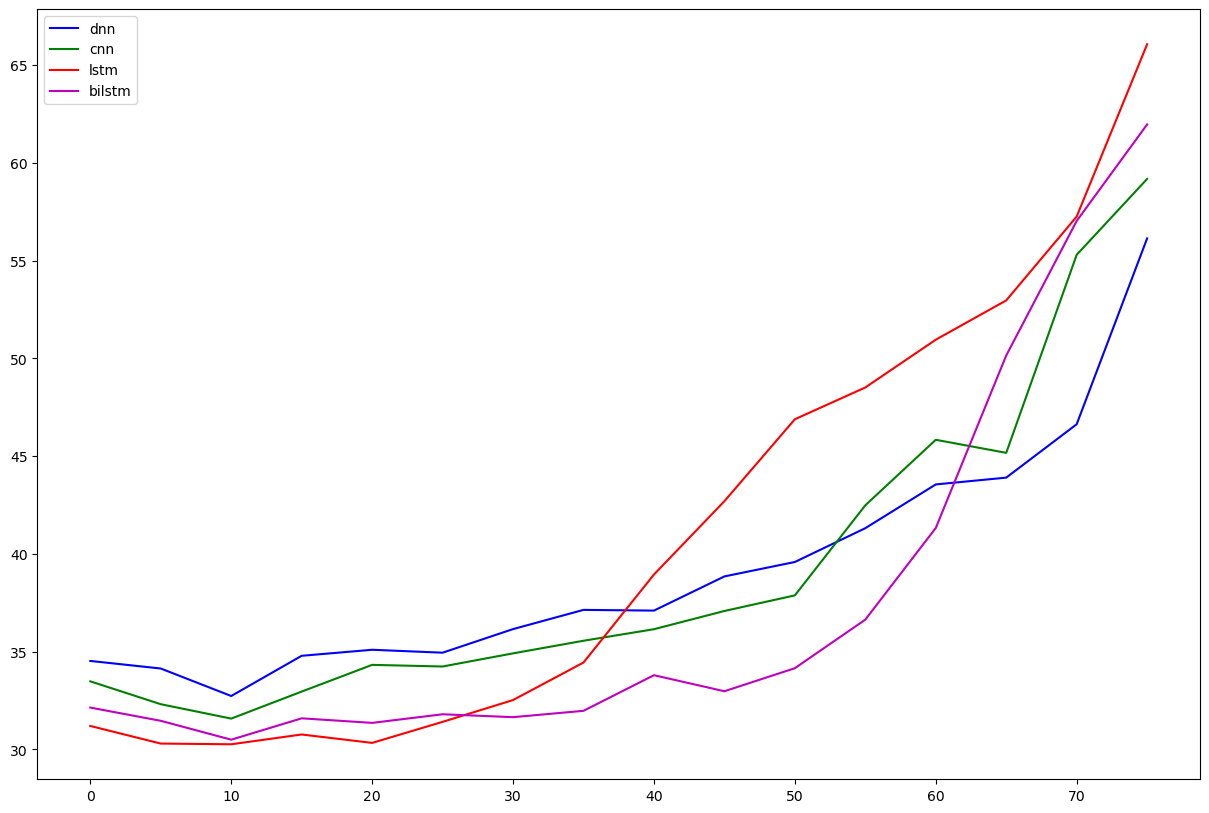

In [79]:
FD001_dnn_rsme = [FD001_ave_rmse['loss'+ str(i) +'_regression_dnn'] for i in range(0,80,5)]
FD001_cnn_rsme = [FD001_ave_rmse['loss'+ str(i) +'_regression_cnn']  for i in range(0,80,5)]
FD001_lstm_rsme = [FD001_ave_rmse['loss'+ str(i) +'_regression_lstm']  for i in range(0,80,5)]
FD001_bilstm_rsme = [FD001_ave_rmse['loss'+ str(i) +'_regression_bilstm'] for i in range(0,80,5)]

x_axes = np.arange(0,80,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,FD001_dnn_rsme,'b',label='dnn')
plt.plot(x_axes,FD001_cnn_rsme,'g',label='cnn')
plt.plot(x_axes,FD001_lstm_rsme,'r',label='lstm')
plt.plot(x_axes,FD001_bilstm_rsme,'m',label='bilstm')
plt.legend()

In [80]:
x = matlab.double(np.arange(0,80,5).tolist())

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{FD001_dnn_rsme},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{FD001_cnn_rsme},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{FD001_lstm_rsme},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{FD001_bilstm_rsme},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

eng.eval("xlabel('Packet Loss Rates')", nargout=0)
eng.eval("ylabel('RMSE')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

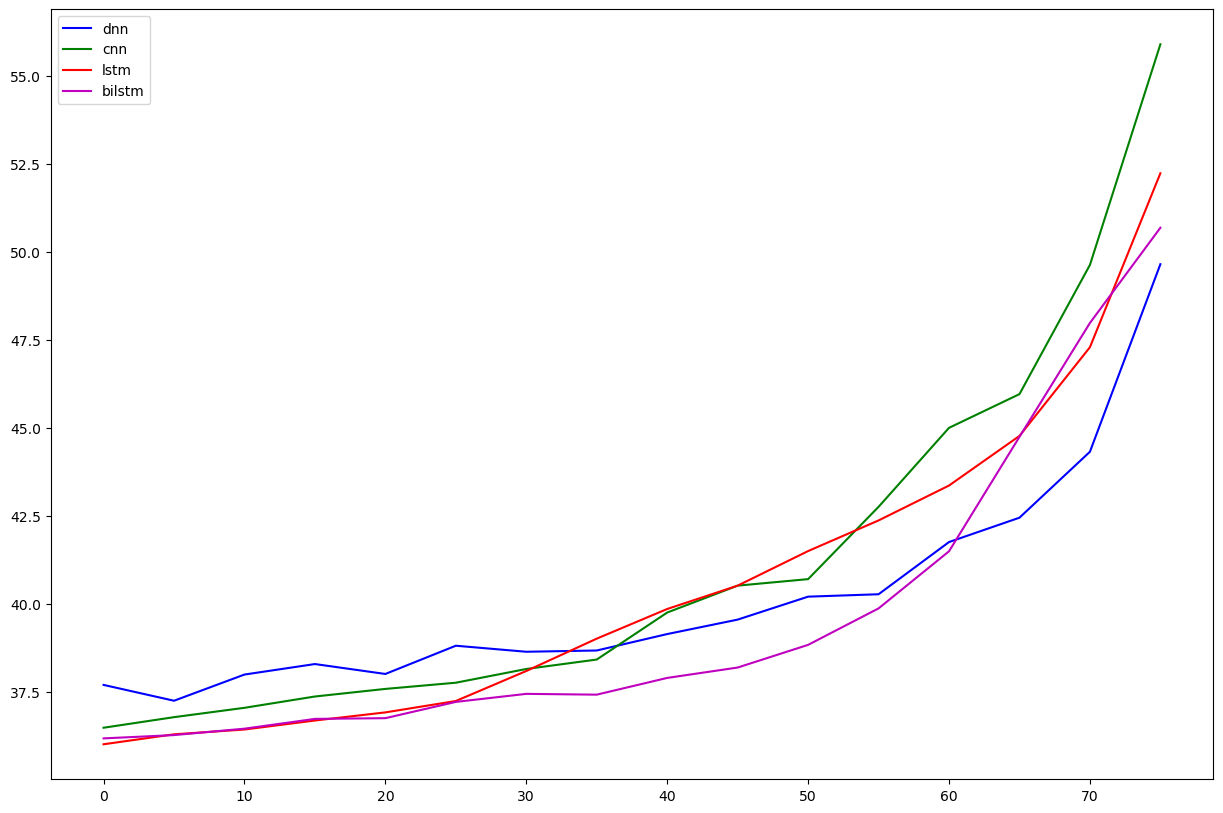

In [14]:
FD004_dnn_rsme = [FD004_ave_rmse['loss'+ str(i) +'_regression_dnn'] for i in range(0,80,5)]
FD004_cnn_rsme = [FD004_ave_rmse['loss'+ str(i) +'_regression_cnn'] for i in range(0,80,5)]
FD004_lstm_rsme = [FD004_ave_rmse['loss'+ str(i) +'_regression_lstm'] for i in range(0,80,5)]
FD004_bilstm_rsme = [FD004_ave_rmse['loss'+ str(i) +'_regression_bilstm'] for i in range(0,80,5)]

x_axes = np.arange(0,80,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,FD004_dnn_rsme,'b',label='dnn')
plt.plot(x_axes,FD004_cnn_rsme,'g',label='cnn')
plt.plot(x_axes,FD004_lstm_rsme,'r',label='lstm')
plt.plot(x_axes,FD004_bilstm_rsme,'m',label='bilstm')
plt.legend()

In [10]:
# Get the machine index
FD001_idx = []
tmp_idx = [0,0]

last_rul = 130
for i in range(FD001_test_rul.shape[0]):
    tmp_rul = FD001_test_rul[i,0]
    if last_rul < tmp_rul:
        tmp_idx[1] = i
        FD001_idx.append(tmp_idx)
        tmp_idx = [i,0]
    last_rul = tmp_rul
tmp_idx[1] = FD001_test_rul.shape[0]
FD001_idx.append(tmp_idx)


FD002_idx = []
tmp_idx = [0,0]

last_rul = 130
for i in range(FD002_test_rul.shape[0]):
    tmp_rul = FD002_test_rul[i,0]
    if last_rul < tmp_rul:
        tmp_idx[1] = i
        FD002_idx.append(tmp_idx)
        tmp_idx = [i,0]
    last_rul = tmp_rul
tmp_idx[1] = FD002_test_rul.shape[0]
FD002_idx.append(tmp_idx)

FD003_idx = []
tmp_idx = [0,0]

last_rul = 130
for i in range(FD003_test_rul.shape[0]):
    tmp_rul = FD003_test_rul[i,0]
    if last_rul < tmp_rul:
        tmp_idx[1] = i
        FD003_idx.append(tmp_idx)
        tmp_idx = [i,0]
    last_rul = tmp_rul
tmp_idx[1] = FD003_test_rul.shape[0]
FD003_idx.append(tmp_idx)

FD004_idx = []
tmp_idx = [0,0]

last_rul = 130
for i in range(FD004_test_rul.shape[0]):
    tmp_rul = FD004_test_rul[i,0]
    if last_rul < tmp_rul:
        tmp_idx[1] = i
        FD004_idx.append(tmp_idx)
        tmp_idx = [i,0]
    last_rul = tmp_rul
tmp_idx[1] = FD004_test_rul.shape[0]
FD004_idx.append(tmp_idx)


In [29]:
FD001_machine_id = random.randint(0,len(FD001_idx))
FD001_machine_idx = FD001_idx[FD001_machine_id]

dnn_result = []
cnn_result = []
lstm_result = []
bilstm_result = []
for tmp_key in FD001_ave_regression.keys():
    if 'dnn' in tmp_key:
        dnn_result.append(FD001_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]])
    elif 'cnn' in tmp_key:
        cnn_result.append(FD001_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]])
    elif 'bilstm' in tmp_key:
        bilstm_result.append(np.expand_dims(FD001_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]],axis=1))
    else:
        lstm_result.append(np.expand_dims(FD001_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]],axis=1))

gt_len = FD001_machine_idx[1] - FD001_machine_idx[0]
x = matlab.double(np.arange(0,gt_len).tolist())
# 16 different color
custom_colors = [
    '#FF0000', # red
    '#00FF00', # green
    '#0000FF', # blue
    '#FFFF00', # yellow
    '#00FFFF', # cyan
    '#FF00FF', # magenta
    '#800000', # maroon
    '#008000', # dark green
    '#000080', # navy
    '#808000', # olive
    '#008080', # teal
    '#800080', # purple
    '#FFA500', # orange
    '#A52A2A', # brown
    '#00FF7F', # spring green
    '#FF1493'  # deep pink
]

print(f'Machine id: {FD001_machine_id}')
# DNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p1 = plot({x},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(dnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{dnn_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# CNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p2 = plot({x},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(cnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{cnn_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# BiLSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p3 = plot({x},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(bilstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{bilstm_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# LSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p4 = plot({x},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(lstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{lstm_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)



Machine id: 12

p1 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  ]
              YData: [130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130  ]

  Use GET to show all properties


p2 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  ]
        

In [32]:
FD004_machine_id = random.randint(0,len(FD004_idx))
FD004_machine_idx = FD004_idx[FD004_machine_id]

dnn_result = []
cnn_result = []
lstm_result = []
bilstm_result = []
for tmp_key in FD004_ave_regression.keys():
    if 'dnn' in tmp_key:
        dnn_result.append(FD004_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]])
    elif 'cnn' in tmp_key:
        cnn_result.append(FD004_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]])
    elif 'bilstm' in tmp_key:
        bilstm_result.append(np.expand_dims(FD004_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]],axis=1))
    else:
        lstm_result.append(np.expand_dims(FD004_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]],axis=1))

gt_len = FD004_machine_idx[1] - FD004_machine_idx[0]
x = matlab.double(np.arange(0,gt_len).tolist())
# 16 different color
custom_colors = [
    '#FF0000', # red
    '#00FF00', # green
    '#0000FF', # blue
    '#FFFF00', # yellow
    '#00FFFF', # cyan
    '#FF00FF', # magenta
    '#800000', # maroon
    '#008000', # dark green
    '#000080', # navy
    '#808000', # olive
    '#008080', # teal
    '#800080', # purple
    '#FFA500', # orange
    '#A52A2A', # brown
    '#00FF7F', # spring green
    '#FF1493'  # deep pink
]

print(f'Machine id: {FD004_machine_id}')
# DNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p5 = plot({x},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(dnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{dnn_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# CNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p6 = plot({x},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(cnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{cnn_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# BiLSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p7 = plot({x},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(bilstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{bilstm_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# LSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p8 = plot({x},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(lstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x},{lstm_result[i]},'Color','{color}','DisplayName','{i*5}%')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)



Machine id: 85

p5 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  ]
              YData: [119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101 100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77  ]

  Use GET to show all properties


p6 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  ]
       

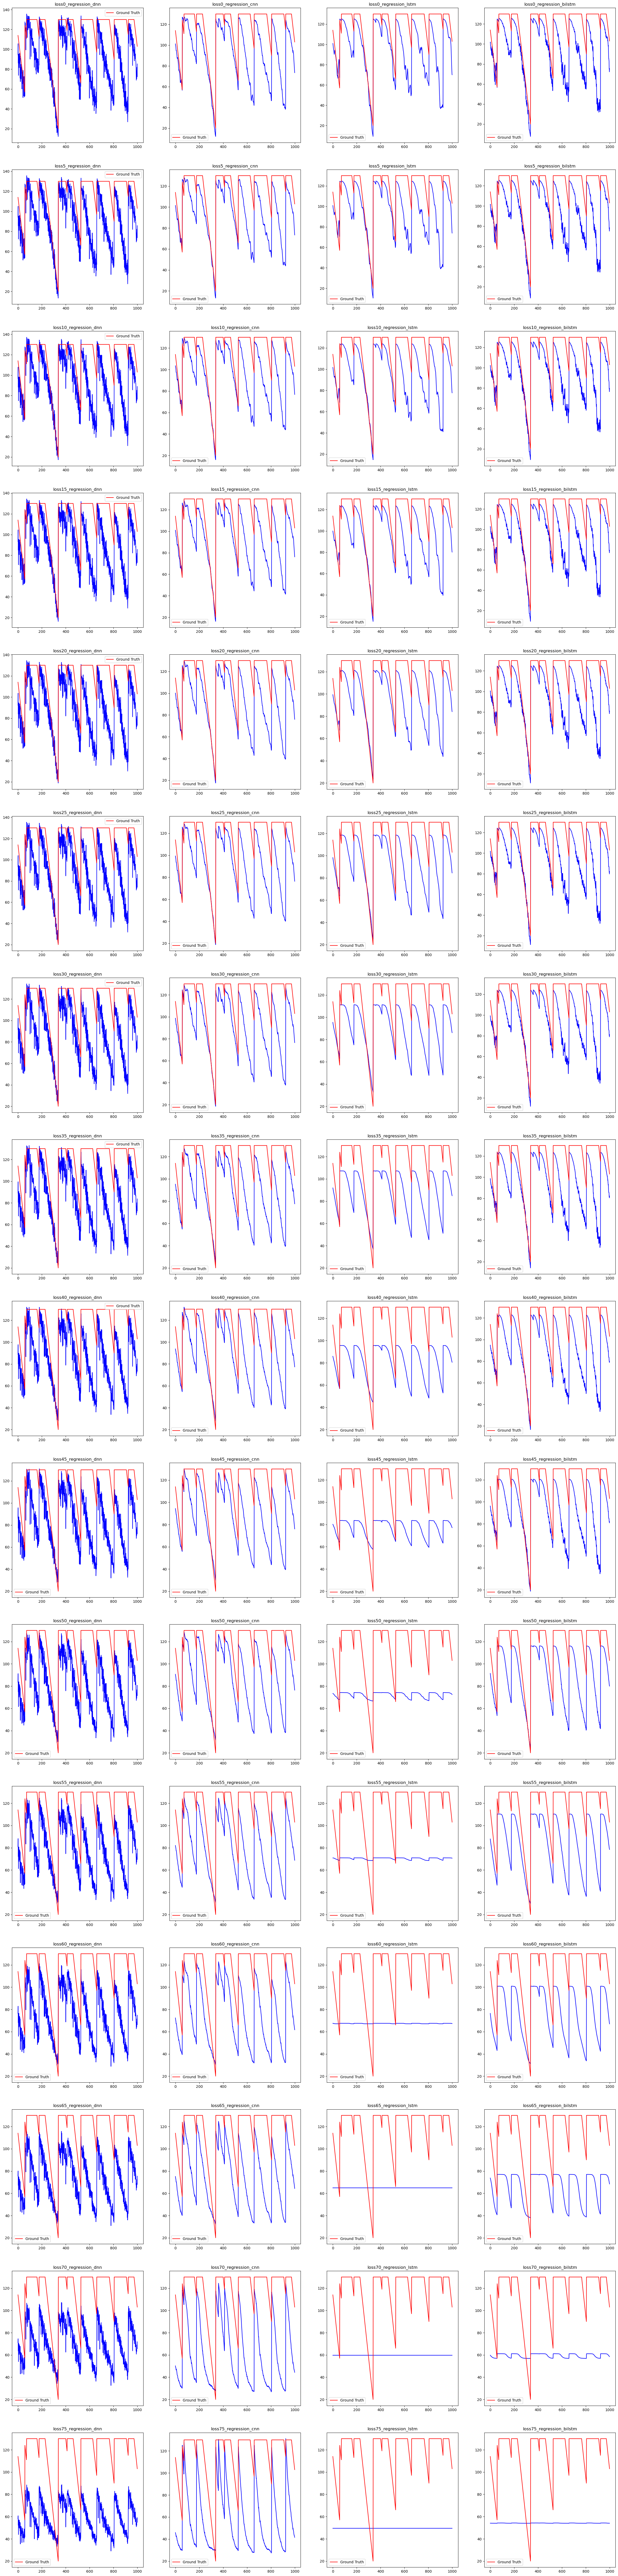

In [110]:
'''
Plot all the regression data
'''
fig, axes = plt.subplots(16,4, figsize=(30,128))
axes = axes.flatten()

for tmp_key, ax in zip(FD001_ave_regression.keys(), axes):
    ax.plot(np.arange(1000),FD001_ave_regression[tmp_key][:,-1][2000:3000],'b')
    ax.plot(np.arange(1000),FD001_test_rul[2000:3000],'r',label='Ground Truth')
    ax.legend()
    ax.set_title(tmp_key)


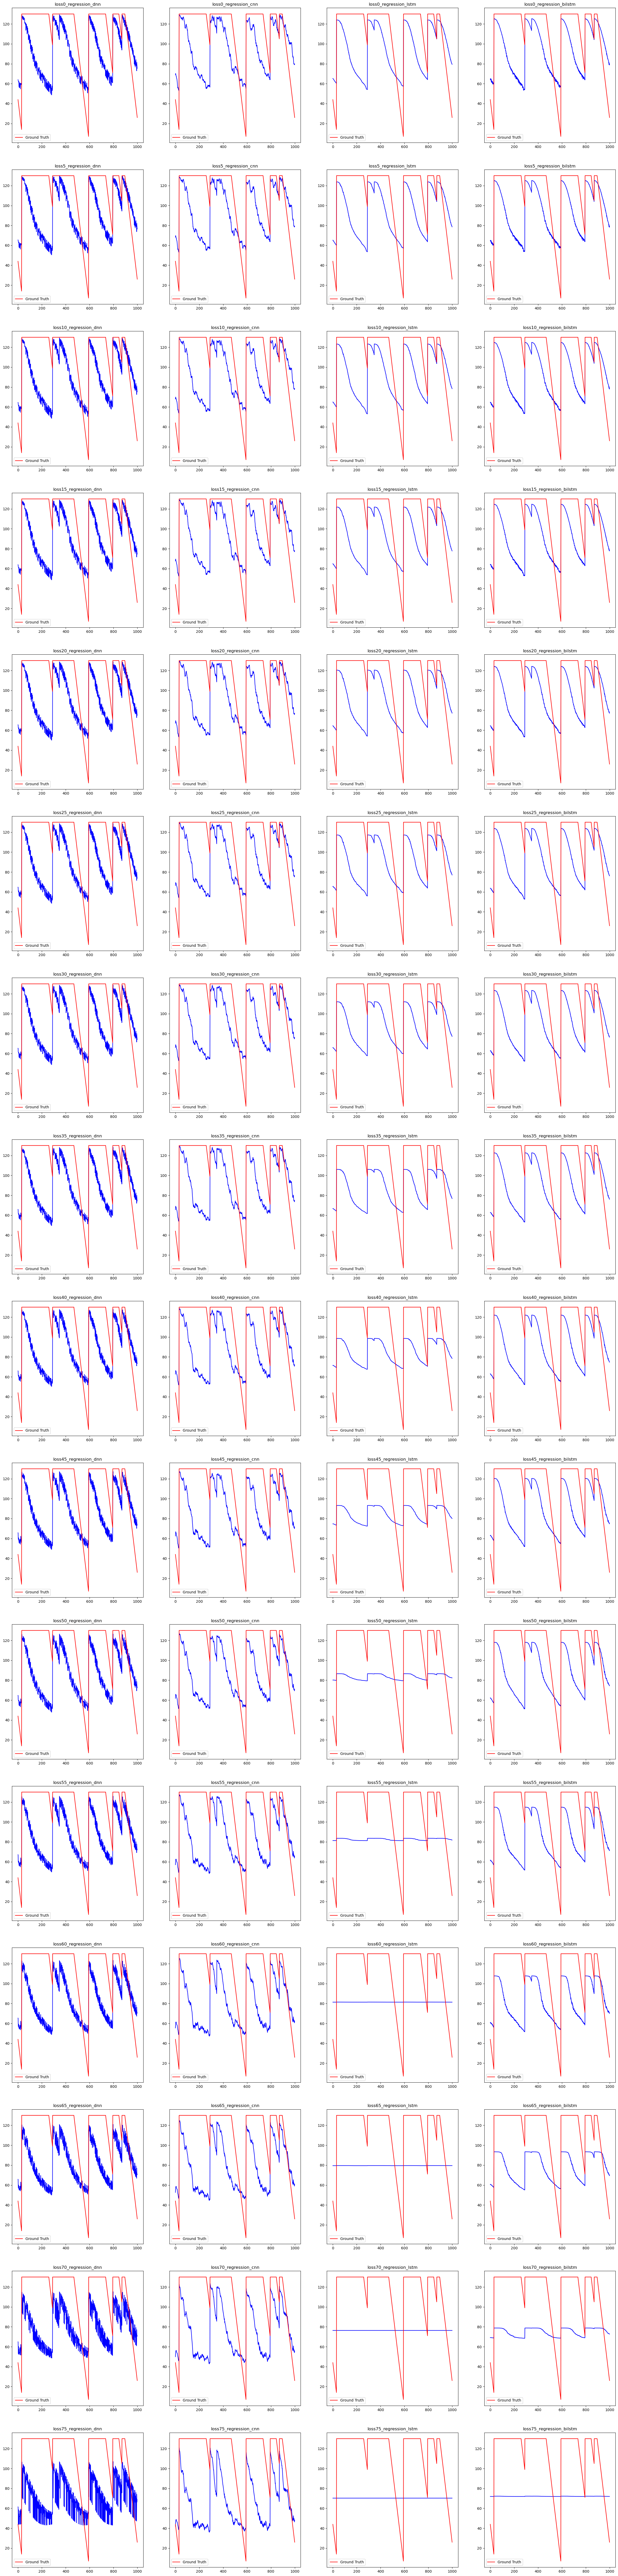

In [13]:
'''
Plot all the regression data
'''
fig, axes = plt.subplots(16,4, figsize=(30,128))
axes = axes.flatten()

for tmp_key, ax in zip(FD004_ave_regression.keys(), axes):
    ax.plot(np.arange(1000),FD004_ave_regression[tmp_key][:,-1][1000:2000],'b')
    ax.plot(np.arange(1000),FD004_test_rul[1000:2000],'r',label='Ground Truth')
    ax.legend()
    ax.set_title(tmp_key)

In [11]:
window_size = ['_window20','_window25','_window30','_window35','_window40','_window45','_window50','_window55','_window60']
file_name = ['FD001','FD002','FD003','FD004']

window_result = {}
window_ave_regression = {}

for tmp_file in file_name:
    for tmp_algo in algo_type:
        for tmp_window in window_size:
            tmp_key = tmp_file + '_loss65_' + model_type[1] + tmp_algo + tmp_window
            tmp_load_file = f'result/{tmp_file}/{tmp_key}.p'
            window_result[tmp_key] = pickle.load(open(tmp_load_file,'rb'))
            window_ave_regression[tmp_key] = np.mean(window_result[tmp_key],axis=0)

In [12]:
'''
Calculate RMSE
'''
window_all_rmse = {}
window_ave_rmse = {}

for tmp_key in window_result.keys():
    window_all_rmse[tmp_key] = []
    if 'FD001' in tmp_key:
        tmp_rul = FD001_test_rul
    elif 'FD002' in tmp_key:
        tmp_rul = FD002_test_rul
    elif 'FD003' in tmp_key:
        tmp_rul = FD003_test_rul
    else:
        tmp_rul = FD004_test_rul

    if 'dnn' in tmp_key or 'cnn' in tmp_key:
        for tmp_pre in window_result[tmp_key]:
            window_all_rmse[tmp_key].append(root_mean_squared_error(tmp_rul, tmp_pre[:,-1]).numpy())
    else:
        for tmp_pre in window_result[tmp_key]:
            window_all_rmse[tmp_key].append(root_mean_squared_error(tmp_rul, tmp_pre).numpy())
    # print(all_rmse)
    window_ave_rmse[tmp_key] = np.mean(window_all_rmse[tmp_key])

In [13]:
window_ave_rmse.keys()

dict_keys(['FD001_loss65_regression_dnn_window20', 'FD001_loss65_regression_dnn_window25', 'FD001_loss65_regression_dnn_window30', 'FD001_loss65_regression_dnn_window35', 'FD001_loss65_regression_dnn_window40', 'FD001_loss65_regression_dnn_window45', 'FD001_loss65_regression_dnn_window50', 'FD001_loss65_regression_dnn_window55', 'FD001_loss65_regression_dnn_window60', 'FD001_loss65_regression_cnn_window20', 'FD001_loss65_regression_cnn_window25', 'FD001_loss65_regression_cnn_window30', 'FD001_loss65_regression_cnn_window35', 'FD001_loss65_regression_cnn_window40', 'FD001_loss65_regression_cnn_window45', 'FD001_loss65_regression_cnn_window50', 'FD001_loss65_regression_cnn_window55', 'FD001_loss65_regression_cnn_window60', 'FD001_loss65_regression_lstm_window20', 'FD001_loss65_regression_lstm_window25', 'FD001_loss65_regression_lstm_window30', 'FD001_loss65_regression_lstm_window35', 'FD001_loss65_regression_lstm_window40', 'FD001_loss65_regression_lstm_window45', 'FD001_loss65_regressio

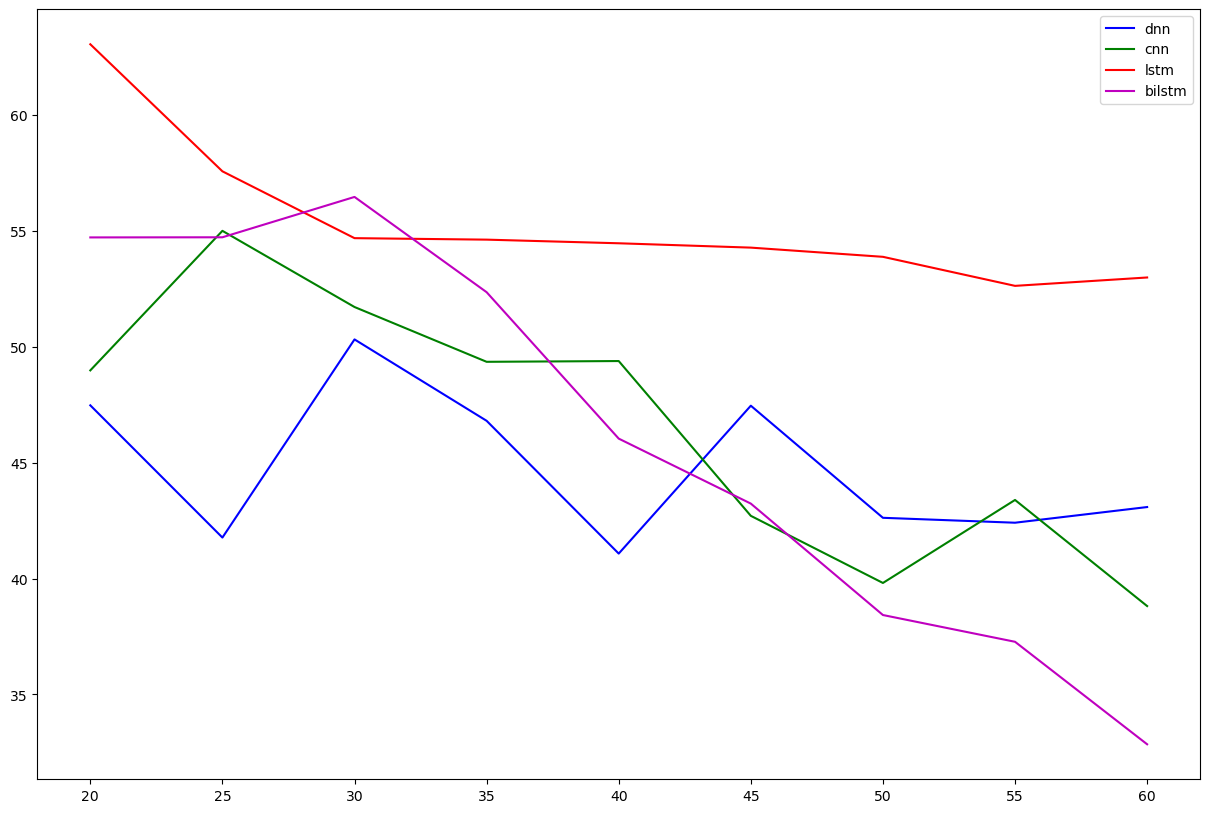

In [14]:
FD001_dnn_rsme = [window_ave_rmse['FD001_loss65_regression_dnn_window'+ str(i)] for i in range(20,65,5)]
FD001_cnn_rsme = [window_ave_rmse['FD001_loss65_regression_cnn_window'+ str(i)] for i in range(20,65,5)]
FD001_lstm_rsme = [window_ave_rmse['FD001_loss65_regression_lstm_window'+ str(i)] for i in range(20,65,5)]
FD001_bilstm_rsme = [window_ave_rmse['FD001_loss65_regression_bilstm_window'+ str(i)] for i in range(20,65,5)]

x_axes = np.arange(20,65,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,FD001_dnn_rsme,'b',label='dnn')
plt.plot(x_axes,FD001_cnn_rsme,'g',label='cnn')
plt.plot(x_axes,FD001_lstm_rsme,'r',label='lstm')
plt.plot(x_axes,FD001_bilstm_rsme,'m',label='bilstm')
plt.legend()

In [15]:
x = matlab.double(np.arange(20,65,5).tolist())

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{FD001_dnn_rsme},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{FD001_cnn_rsme},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{FD001_lstm_rsme},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{FD001_bilstm_rsme},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Size of sliding window')", nargout=0)
eng.eval("ylabel('RMSE')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

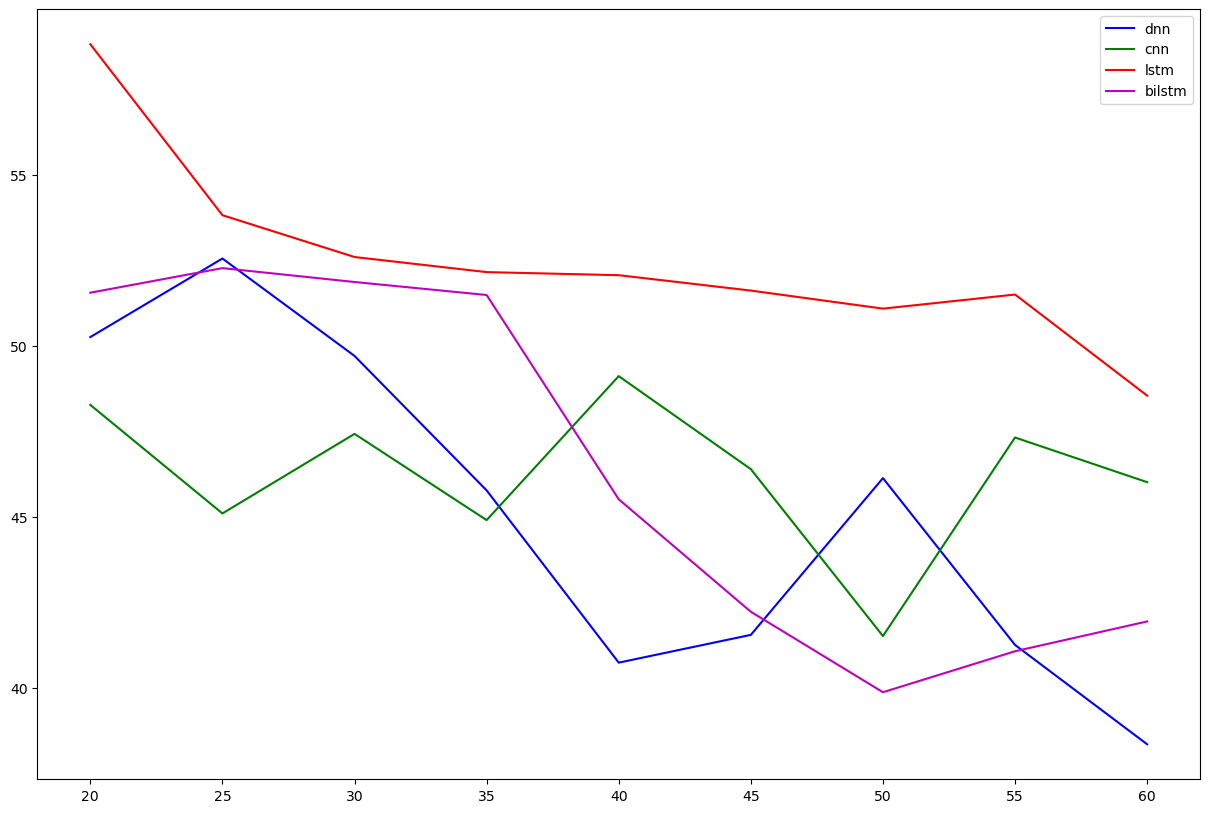

In [16]:
FD002_dnn_rsme = [window_ave_rmse['FD002_loss65_regression_dnn_window'+ str(i)] for i in range(20,65,5)]
FD002_cnn_rsme = [window_ave_rmse['FD002_loss65_regression_cnn_window'+ str(i)] for i in range(20,65,5)]
FD002_lstm_rsme = [window_ave_rmse['FD002_loss65_regression_lstm_window'+ str(i)] for i in range(20,65,5)]
FD002_bilstm_rsme = [window_ave_rmse['FD002_loss65_regression_bilstm_window'+ str(i)] for i in range(20,65,5)]

x_axes = np.arange(20,65,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,FD002_dnn_rsme,'b',label='dnn')
plt.plot(x_axes,FD002_cnn_rsme,'g',label='cnn')
plt.plot(x_axes,FD002_lstm_rsme,'r',label='lstm')
plt.plot(x_axes,FD002_bilstm_rsme,'m',label='bilstm')
plt.legend()

In [18]:
x = matlab.double(np.arange(20,65,5).tolist())

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{FD002_dnn_rsme},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{FD002_cnn_rsme},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{FD002_lstm_rsme},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{FD002_bilstm_rsme},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Size of sliding window')", nargout=0)
eng.eval("ylabel('RMSE')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

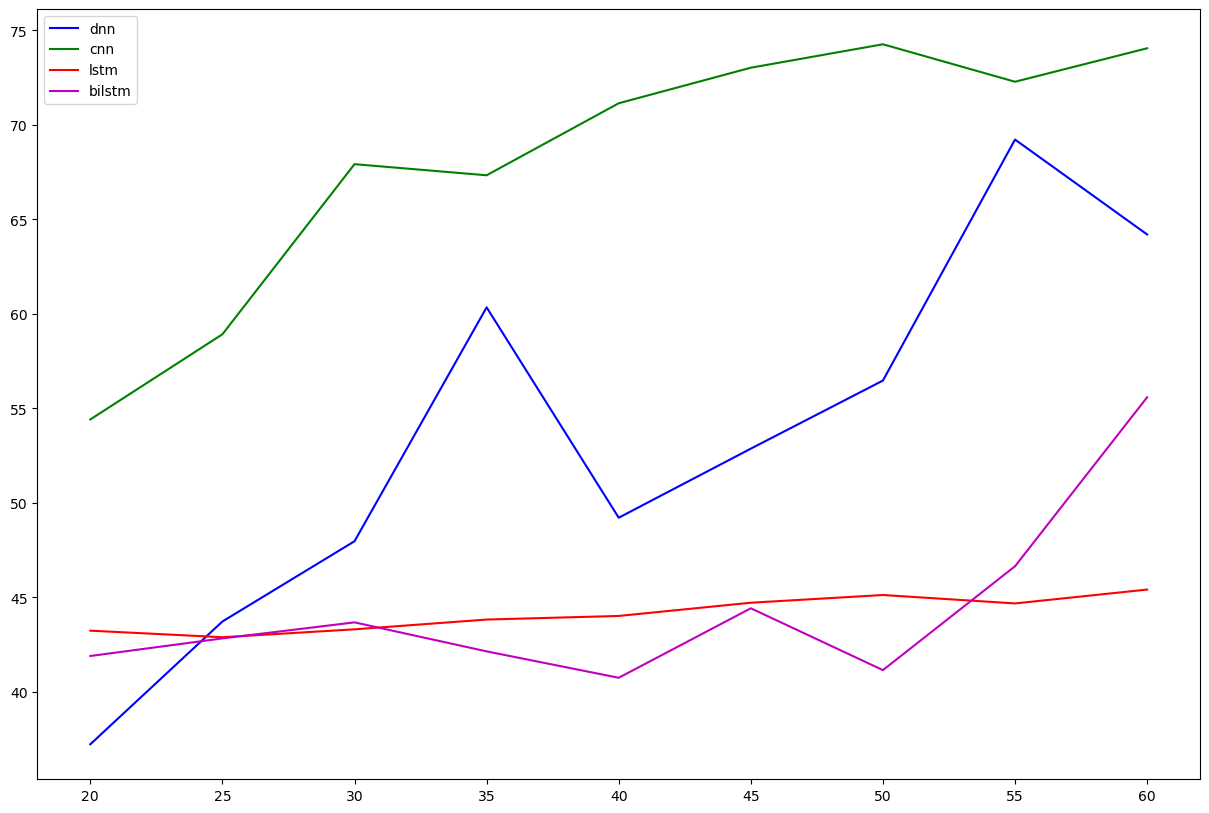

In [19]:
FD003_dnn_rsme = [window_ave_rmse['FD003_loss65_regression_dnn_window'+ str(i)] for i in range(20,65,5)]
FD003_cnn_rsme = [window_ave_rmse['FD003_loss65_regression_cnn_window'+ str(i)] for i in range(20,65,5)]
FD003_lstm_rsme = [window_ave_rmse['FD003_loss65_regression_lstm_window'+ str(i)] for i in range(20,65,5)]
FD003_bilstm_rsme = [window_ave_rmse['FD003_loss65_regression_bilstm_window'+ str(i)] for i in range(20,65,5)]

x_axes = np.arange(20,65,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,FD003_dnn_rsme,'b',label='dnn')
plt.plot(x_axes,FD003_cnn_rsme,'g',label='cnn')
plt.plot(x_axes,FD003_lstm_rsme,'r',label='lstm')
plt.plot(x_axes,FD003_bilstm_rsme,'m',label='bilstm')
plt.legend()

In [20]:
x = matlab.double(np.arange(20,65,5).tolist())

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{FD003_dnn_rsme},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{FD003_cnn_rsme},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{FD003_lstm_rsme},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{FD003_bilstm_rsme},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Size of sliding window')", nargout=0)
eng.eval("ylabel('RMSE')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

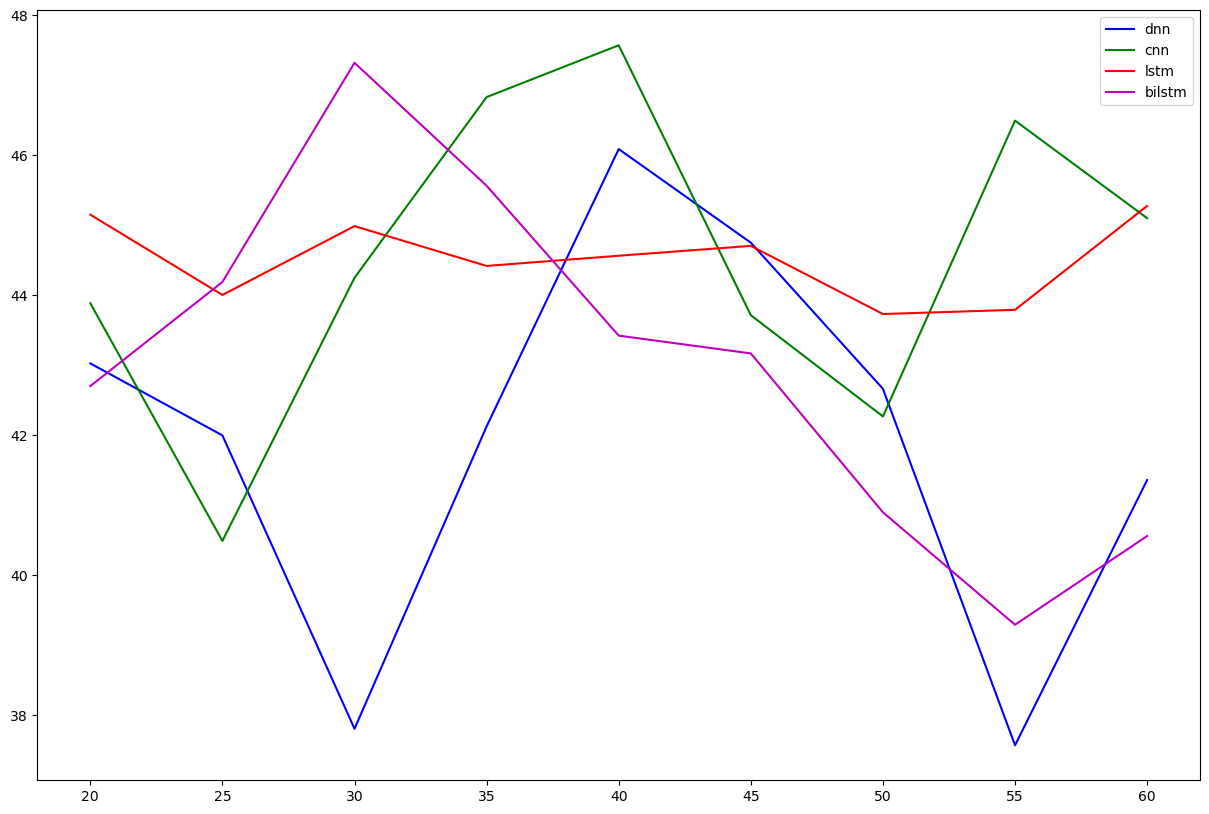

In [21]:
FD004_dnn_rsme = [window_ave_rmse['FD004_loss65_regression_dnn_window'+ str(i)] for i in range(20,65,5)]
FD004_cnn_rsme = [window_ave_rmse['FD004_loss65_regression_cnn_window'+ str(i)] for i in range(20,65,5)]
FD004_lstm_rsme = [window_ave_rmse['FD004_loss65_regression_lstm_window'+ str(i)] for i in range(20,65,5)]
FD004_bilstm_rsme = [window_ave_rmse['FD004_loss65_regression_bilstm_window'+ str(i)] for i in range(20,65,5)]

x_axes = np.arange(20,65,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,FD004_dnn_rsme,'b',label='dnn')
plt.plot(x_axes,FD004_cnn_rsme,'g',label='cnn')
plt.plot(x_axes,FD004_lstm_rsme,'r',label='lstm')
plt.plot(x_axes,FD004_bilstm_rsme,'m',label='bilstm')
plt.legend()

In [22]:
x = matlab.double(np.arange(20,65,5).tolist())

eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)
eng.eval(f"plot({x},{FD004_dnn_rsme},'r','DisplayName','DNN')", nargout=0)
eng.eval(f"plot({x},{FD004_cnn_rsme},'g','DisplayName','CNN')", nargout=0)
eng.eval(f"plot({x},{FD004_lstm_rsme},'b','DisplayName','LSTM')", nargout=0)
eng.eval(f"plot({x},{FD004_bilstm_rsme},'m','DisplayName','BiLSTM')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Size of sliding window')", nargout=0)
eng.eval("ylabel('RMSE')", nargout=0)
eng.eval("legend('Location', 'northeast')", nargout=0)

In [64]:
window_ave_regression.keys()

dict_keys(['FD001_loss65_regression_dnn_window20', 'FD001_loss65_regression_dnn_window25', 'FD001_loss65_regression_dnn_window30', 'FD001_loss65_regression_dnn_window35', 'FD001_loss65_regression_dnn_window40', 'FD001_loss65_regression_dnn_window45', 'FD001_loss65_regression_dnn_window50', 'FD001_loss65_regression_dnn_window55', 'FD001_loss65_regression_dnn_window60', 'FD001_loss65_regression_cnn_window20', 'FD001_loss65_regression_cnn_window25', 'FD001_loss65_regression_cnn_window30', 'FD001_loss65_regression_cnn_window35', 'FD001_loss65_regression_cnn_window40', 'FD001_loss65_regression_cnn_window45', 'FD001_loss65_regression_cnn_window50', 'FD001_loss65_regression_cnn_window55', 'FD001_loss65_regression_cnn_window60', 'FD001_loss65_regression_lstm_window20', 'FD001_loss65_regression_lstm_window25', 'FD001_loss65_regression_lstm_window30', 'FD001_loss65_regression_lstm_window35', 'FD001_loss65_regression_lstm_window40', 'FD001_loss65_regression_lstm_window45', 'FD001_loss65_regressio

In [74]:
FD001_machine_id = random.randint(0,len(FD001_idx))
FD001_machine_idx = FD001_idx[FD001_machine_id]

FD002_machine_id = random.randint(0,len(FD002_idx))
FD002_machine_idx = FD002_idx[FD002_machine_id]

FD003_machine_id = random.randint(0,len(FD003_idx))
FD003_machine_idx = FD003_idx[FD003_machine_id]

FD004_machine_id = random.randint(0,len(FD004_idx))
FD004_machine_idx = FD004_idx[FD004_machine_id]

FD001_dnn_result = []
FD001_cnn_result = []
FD001_lstm_result = []
FD001_bilstm_result = []

FD002_dnn_result = []
FD002_cnn_result = []
FD002_lstm_result = []
FD002_bilstm_result = []

FD003_dnn_result = []
FD003_cnn_result = []
FD003_lstm_result = []
FD003_bilstm_result = []

FD004_dnn_result = []
FD004_cnn_result = []
FD004_lstm_result = []
FD004_bilstm_result = []
for tmp_key in window_ave_regression.keys():
    if 'FD001' in tmp_key:
        if 'dnn' in tmp_key:
            FD001_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD001_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD001_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]],axis=1))
        else:
            FD001_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]],axis=1))

    elif 'FD002' in tmp_key:
        if 'dnn' in tmp_key:
            FD002_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD002_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD002_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]],axis=1))
        else:
            FD002_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]],axis=1))

    elif 'FD003' in tmp_key:
        if 'dnn' in tmp_key:
            FD003_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD003_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD003_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]],axis=1))
        else:
            FD003_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]],axis=1))

    else:
        if 'dnn' in tmp_key:
            FD004_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD004_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD004_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]],axis=1))
        else:
            FD004_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]],axis=1))

gt_len = FD001_machine_idx[1] - FD001_machine_idx[0]
x1 = matlab.double(np.arange(0,gt_len).tolist())

gt_len = FD002_machine_idx[1] - FD002_machine_idx[0]
x2 = matlab.double(np.arange(0,gt_len).tolist())

gt_len = FD003_machine_idx[1] - FD003_machine_idx[0]
x3 = matlab.double(np.arange(0,gt_len).tolist())

gt_len = FD004_machine_idx[1] - FD004_machine_idx[0]
x4 = matlab.double(np.arange(0,gt_len).tolist())
# 16 different color
custom_colors = [
    '#FF0000', # red
    '#00FF00', # green
    '#FFFF00', # yellow
    '#00FFFF', # cyan
    '#FF00FF', # magenta
    '#800000', # maroon
    '#008000', # dark green
    '#000080', # navy
    '#808000', # olive
    '#008080', # teal
    '#800080', # purple
    '#FFA500', # orange
    '#A52A2A', # brown
    '#00FF7F', # spring green
    '#FF1493', # deep pink
    '#0000FF'  # blue
]

print(f'FD001 Machine id: {FD001_machine_id}')
print(f'FD002 Machine id: {FD002_machine_id}')
print(f'FD003 Machine id: {FD003_machine_id}')
print(f'FD004 Machine id: {FD004_machine_id}')
# DNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p9 = plot({x1},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD001_dnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x1},{FD001_dnn_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# CNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p10 = plot({x1},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD001_cnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x1},{FD001_cnn_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# LSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p11 = plot({x1},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD001_lstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x1},{FD001_lstm_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# BiLSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p12 = plot({x1},{FD001_test_rul[FD001_machine_idx[0]:FD001_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD001_bilstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x1},{FD001_bilstm_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

FD001 Machine id: 19
FD002 Machine id: 189
FD003 Machine id: 15
FD004 Machine id: 43

p9 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  ]
              YData: [130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130  ]

  Use GET to show all properties


p10 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 3

In [77]:
FD001_machine_id = random.randint(0,len(FD001_idx))
FD001_machine_idx = FD001_idx[FD001_machine_id]

FD002_machine_id = random.randint(0,len(FD002_idx))
FD002_machine_idx = FD002_idx[FD002_machine_id]

FD003_machine_id = random.randint(0,len(FD003_idx))
FD003_machine_idx = FD003_idx[FD003_machine_id]

FD004_machine_id = random.randint(0,len(FD004_idx))
FD004_machine_idx = FD004_idx[FD004_machine_id]

FD001_dnn_result = []
FD001_cnn_result = []
FD001_lstm_result = []
FD001_bilstm_result = []

FD002_dnn_result = []
FD002_cnn_result = []
FD002_lstm_result = []
FD002_bilstm_result = []

FD003_dnn_result = []
FD003_cnn_result = []
FD003_lstm_result = []
FD003_bilstm_result = []

FD004_dnn_result = []
FD004_cnn_result = []
FD004_lstm_result = []
FD004_bilstm_result = []
for tmp_key in window_ave_regression.keys():
    if 'FD001' in tmp_key:
        if 'dnn' in tmp_key:
            FD001_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD001_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD001_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]],axis=1))
        else:
            FD001_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD001_machine_idx[0]:FD001_machine_idx[1]],axis=1))

    elif 'FD002' in tmp_key:
        if 'dnn' in tmp_key:
            FD002_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD002_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD002_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]],axis=1))
        else:
            FD002_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD002_machine_idx[0]:FD002_machine_idx[1]],axis=1))

    elif 'FD003' in tmp_key:
        if 'dnn' in tmp_key:
            FD003_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD003_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD003_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]],axis=1))
        else:
            FD003_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD003_machine_idx[0]:FD003_machine_idx[1]],axis=1))

    else:
        if 'dnn' in tmp_key:
            FD004_dnn_result.append(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]])
        elif 'cnn' in tmp_key:
            FD004_cnn_result.append(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]])
        elif 'bilstm' in tmp_key:
            FD004_bilstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]],axis=1))
        else:
            FD004_lstm_result.append(np.expand_dims(window_ave_regression[tmp_key][:,-1][FD004_machine_idx[0]:FD004_machine_idx[1]],axis=1))

gt_len = FD001_machine_idx[1] - FD001_machine_idx[0]
x1 = matlab.double(np.arange(0,gt_len).tolist())

gt_len = FD002_machine_idx[1] - FD002_machine_idx[0]
x2 = matlab.double(np.arange(0,gt_len).tolist())

gt_len = FD003_machine_idx[1] - FD003_machine_idx[0]
x3 = matlab.double(np.arange(0,gt_len).tolist())

gt_len = FD004_machine_idx[1] - FD004_machine_idx[0]
x4 = matlab.double(np.arange(0,gt_len).tolist())
# 16 different color
custom_colors = [
    '#FF0000', # red
    '#00FF00', # green
    '#FFFF00', # yellow
    '#00FFFF', # cyan
    '#FF00FF', # magenta
    '#800000', # maroon
    '#008000', # dark green
    '#000080', # navy
    '#808000', # olive
    '#008080', # teal
    '#800080', # purple
    '#FFA500', # orange
    '#A52A2A', # brown
    '#00FF7F', # spring green
    '#FF1493', # deep pink
    '#0000FF'  # blue
]

print(f'FD001 Machine id: {FD001_machine_id}')
print(f'FD002 Machine id: {FD002_machine_id}')
print(f'FD003 Machine id: {FD003_machine_id}')
print(f'FD004 Machine id: {FD004_machine_id}')
# DNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p9 = plot({x4},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD004_dnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x4},{FD004_dnn_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# CNN figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p10 = plot({x4},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD004_cnn_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x4},{FD004_cnn_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# LSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p11 = plot({x4},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD004_lstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x4},{FD004_lstm_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

# BiLSTM figure
eng.eval("figure()", nargout=0)
eng.eval("hold on", nargout=0)
eng.eval("grid on", nargout=0)

eng.eval(f"p12 = plot({x4},{FD004_test_rul[FD004_machine_idx[0]:FD004_machine_idx[1]]},'b','DisplayName','Ground Truth')", nargout=0)
for i in range(len(FD004_bilstm_result)):
    color = custom_colors[i]
    eng.eval(f"plot({x4},{FD004_bilstm_result[i]},'Color','{color}','DisplayName','{(i+4)*5}')", nargout=0)

eng.eval("legend('Location', 'eastoutside')", nargout=0)
eng.title('65% Packet Loss', nargout=0)
eng.eval("xlabel('Time(Cycles)')", nargout=0)
eng.eval("ylabel('Remaining Life Left(Cycles)')", nargout=0)

FD001 Machine id: 68
FD002 Machine id: 88
FD003 Machine id: 20
FD004 Machine id: 171

p9 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  ]
              YData: [130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130 130  ]

  Use GET to show all properties


p10 = 

  Line (Ground Truth) with properties:

              Color: [0 0 1]
          LineStyle: '-'
          LineWidth: 0.5000
             Marker: 'none'
         MarkerSize: 6
    MarkerFaceColor: 'none'
              XData: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 3